## POS tagging using modified Viterbi

### Data Preparation

In [61]:
#Importing libraries
import nltk
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from collections import defaultdict

In [19]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
print(len(nltk_data))


3914


In [20]:
x_train ,x_test = train_test_split(nltk_data,test_size=0.05) 
print(len(x_train))
print(len(x_test))

3718
196


In [21]:
# Getting list of tagged words
train_tagged_words = [tup for sent in x_train for tup in sent]
len(train_tagged_words)

95824

In [22]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['About',
 '20,000',
 'sets',
 'of',
 'Learning',
 'Materials',
 'teachers',
 "'",
 'binders',
 'have']

In [23]:
# vocabulary
V = set(tokens)
print(len(V))

12058


In [24]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [25]:
print(T)

{'VERB', 'DET', '.', 'PRT', 'ADJ', 'X', 'ADP', 'NUM', 'ADV', 'PRON', 'NOUN', 'CONJ'}


In [26]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(x_train)
unigram_tagger.evaluate(x_test)

0.8957131079967023

Thus we can observe that Lexicon based Unittager gives an accuracy of approx 89%.

### Build the vanilla Viterbi based POS tagger

#### Emission Probablities

In [28]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [29]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [34]:
# examples

# Android
print("\n", "Android")
print(word_given_tag('Android','NOUN'))

# Google
print("\n", "Google")
print(word_given_tag('Google','NOUN'))

# flights
print("\n", "flights")
print(word_given_tag('flights', 'NOUN'))


# will
print("\n", "will")
print(word_given_tag('will', 'NOUN'))
print(word_given_tag('will', 'VERB'))



 Android
(0, 27486)

 Google
(0, 27486)

 flights
(2, 27486)

 will
(1, 27486)
(265, 12924)


#### Transition Probabilities

In [35]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [36]:
# examples
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('NOUN', 'ADJ'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1('.', 'NOUN'))
print(t2_given_t1('PRON', 'PRON'))
print(t2_given_t1('VERB', 'NOUN'))

(4262, 6084)
(4262, 6084)
(5323, 8311)
(1426, 12924)
(6581, 27486)
(20, 2599)
(4047, 27486)


In [37]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('NOUN', '.'))


(1931, 11139)
(982, 11139)
(2475, 11139)
(2475, 11139)


In [38]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [39]:
tags_matrix

array([[1.69993803e-01, 1.33936867e-01, 3.42773125e-02, 3.14144231e-02,
        6.48406073e-02, 2.17038065e-01, 9.12256241e-02, 2.31352523e-02,
        8.24822038e-02, 3.56700718e-02, 1.10337354e-01, 5.64840622e-03],
       [3.95860896e-02, 5.53483330e-03, 1.76874027e-02, 2.40644935e-04,
        2.04427868e-01, 4.50006016e-02, 9.26482957e-03, 2.20190100e-02,
        1.17916018e-02, 3.72999650e-03, 6.40476465e-01, 2.40644935e-04],
       [8.81587192e-02, 1.73354879e-01, 9.32758749e-02, 2.15459196e-03,
        4.44384590e-02, 2.76505966e-02, 9.09417346e-02, 8.12460706e-02,
        5.25181778e-02, 6.50866330e-02, 2.22192302e-01, 5.88921793e-02],
       [4.01106060e-01, 1.00520492e-01, 4.29407954e-02, 1.95185421e-03,
        8.49056616e-02, 1.26870526e-02, 2.04944704e-02, 5.72543927e-02,
        1.04098897e-02, 1.85426157e-02, 2.46909559e-01, 2.27716332e-03],
       [1.21630505e-02, 4.60223528e-03, 6.54174909e-02, 1.10124918e-02,
        6.65680468e-02, 2.03813277e-02, 7.77449012e-02, 1.95

In [40]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [41]:
tags_df

,VERB,DET,.,PRT,ADJ,X,ADP,NUM,ADV,PRON,NOUN,CONJ
VERB,0.169994,0.133937,0.034277,0.031414,0.064841,0.217038,0.091226,0.023135,0.082482,0.035670,0.110337,0.005648
DET,0.039586,0.005535,0.017687,0.000241,0.204428,0.045001,0.009265,0.022019,0.011792,0.003730,0.640476,0.000241
.,0.088159,0.173355,0.093276,0.002155,0.044438,0.027651,0.090942,0.081246,0.052518,0.065087,0.222192,0.058892
PRT,0.401106,0.100520,0.042941,0.001952,0.084906,0.012687,0.020494,0.057254,0.010410,0.018543,0.246910,0.002277
ADJ,0.012163,0.004602,0.065417,0.011012,0.066568,0.020381,0.077745,0.019560,0.004438,0.000657,0.700526,0.016930
X,0.203368,0.055609,0.165872,0.184779,0.016683,0.074674,0.142834,0.002860,0.026215,0.055132,0.061646,0.010327
ADP,0.008226,0.325534,0.039850,0.001175,0.106303,0.034615,0.016987,0.061645,0.013568,0.068803,0.322543,0.000748
NUM,0.017539,0.003270,0.117122,0.027051,0.033294,0.210166,0.034780,0.185493,0.003270,0.001189,0.352854,0.013971
ADV,0.346192,0.070227,0.134520,0.014177,0.129575,0.022750,0.117046,0.030003,0.080778,0.015826,0.031652,0.007254
PRON,0.482878,0.009619,0.040785,0.013082,0.072720,0.094652,0.021162,0.007695,0.034629,0.007695,0.210081,0.005002


In [42]:
tags_df.loc['.', :]

VERB    0.088159
DET     0.173355
.       0.093276
PRT     0.002155
ADJ     0.044438
X       0.027651
ADP     0.090942
NUM     0.081246
ADV     0.052518
PRON    0.065087
NOUN    0.222192
CONJ    0.058892
Name: ., dtype: float32

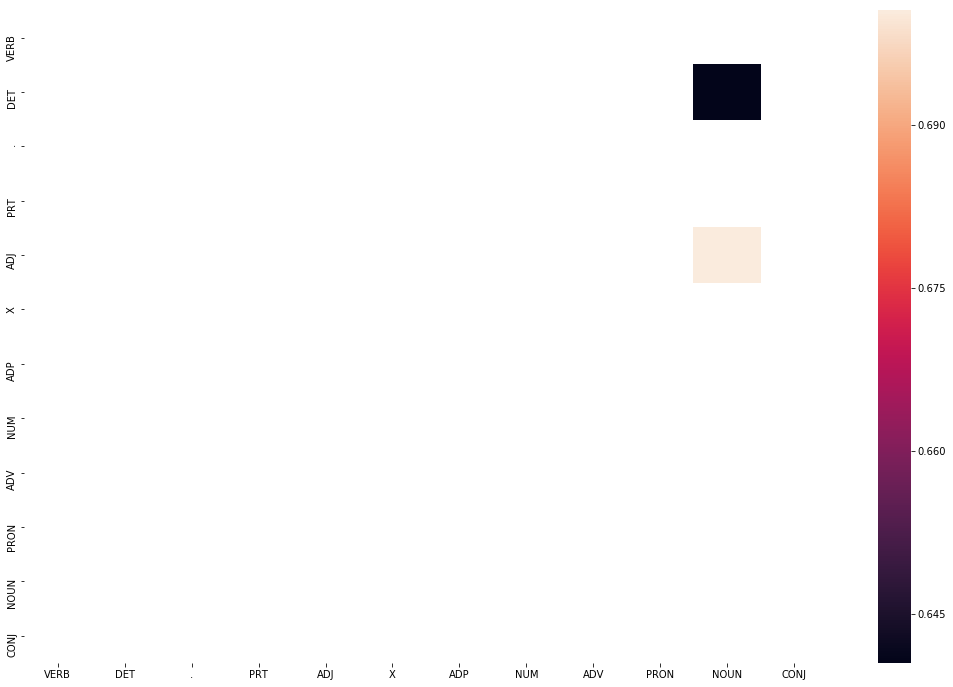

In [43]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Viterbi Algorithm

In [44]:
len(train_tagged_words)

95824

In [50]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#accuracy
def check_accuracy():
    check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
    accuracy = len(check)/len(tagged_seq)
    return accuracy


### Evaluating test set

In [46]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(x_test)) for x in range(5)]

# list of sents
test_run = [x_test[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('This', 'DET'),
  ('species', 'NOUN'),
  ('of', 'ADP'),
  ('congressional', 'ADJ'),
  ('action', 'NOUN'),
  ('is', 'VERB'),
  ('predicated', 'VERB'),
  ('*-50', 'X'),
  ('on', 'ADP'),
  ('an', 'DET'),
  ('interpretation', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('appropriations', 'NOUN'),
  ('clause', 'NOUN'),
  ('that', 'DET'),
  ('*T*-1', 'X'),
  ('is', 'VERB'),
  ('erroneous', 'ADJ'),
  ('and', 'CONJ'),
  ('unconstitutional', 'ADJ'),
  ('.', '.')],
 [('The', 'DET'),
  ('Soviets', 'NOUN'),
  (',', '.'),
  ('who', 'PRON'),
  ('*T*-12', 'X'),
  ('normally', 'ADV'),
  ('have', 'VERB'),
  ('few', 'ADJ'),
  ('clients', 'NOUN'),
  ('other', 'ADJ'),
  ('than', 'ADP'),
  ('the', 'DET'),
  ('state', 'NOUN'),
  (',', '.'),
  ('will', 'VERB'),
  ('get', 'VERB'),
  ('``', '.'),
  ('exposure', 'NOUN'),
  ('to', 'PRT'),
  ('a', 'DET'),
  ('market', 'NOUN'),
  ('system', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('he', 'PRON'),
  ('says', 'VERB'),
  ('0', 'X'),
  ('*T*-1', 'X'),
  ('.', '.')

In [47]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [48]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  22.124781131744385
[('This', 'DET'), ('species', 'VERB'), ('of', 'ADP'), ('congressional', 'ADJ'), ('action', 'NOUN'), ('is', 'VERB'), ('predicated', 'VERB'), ('*-50', 'X'), ('on', 'ADP'), ('an', 'DET'), ('interpretation', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('appropriations', 'NOUN'), ('clause', 'NOUN'), ('that', 'ADP'), ('*T*-1', 'X'), ('is', 'VERB'), ('erroneous', 'VERB'), ('and', 'CONJ'), ('unconstitutional', 'ADJ'), ('.', '.'), ('The', 'DET'), ('Soviets', 'NOUN'), (',', '.'), ('who', 'PRON'), ('*T*-12', 'X'), ('normally', 'ADV'), ('have', 'VERB'), ('few', 'ADJ'), ('clients', 'NOUN'), ('other', 'ADJ'), ('than', 'ADP'), ('the', 'DET'), ('state', 'NOUN'), (',', '.'), ('will', 'VERB'), ('get', 'VERB'), ('``', '.'), ('exposure', 'NOUN'), ('to', 'PRT'), ('a', 'DET'), ('market', 'NOUN'), ('system', 'NOUN'), (',', '.'), ("''", '.'), ('he', 'PRON'), ('says', 'VERB'), ('0', 'X'), ('*T*-1', 'X'), ('.', '.'), ('Much', 'ADV'), ('of', 'ADP'), ('the', 'DET'), ('800', 

In [55]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('This', 'DET'), (('species', 'VERB'), ('species', 'NOUN'))],
 [('clause', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('is', 'VERB'), (('erroneous', 'VERB'), ('erroneous', 'ADJ'))],
 [('.', '.'), (('Much', 'ADV'), ('Much', 'ADJ'))],
 [('Jack', 'NOUN'), (('Lawless', 'VERB'), ('Lawless', 'NOUN'))],
 [('of', 'ADP'), (('US', 'VERB'), ('US', 'NOUN'))],
 [('US', 'NOUN'), (('Sprint', 'VERB'), ('Sprint', 'NOUN'))],
 [('.', '.'), (('Activity', 'VERB'), ('Activity', 'NOUN'))],
 [('in', 'ADP'), (('derivative', 'VERB'), ('derivative', 'ADJ'))],
 [('The', 'DET'), (('Thai', 'VERB'), ('Thai', 'NOUN'))],
 [('Thai', 'NOUN'), (('cabinet', 'VERB'), ('cabinet', 'NOUN'))],
 [('Minister', 'NOUN'), (('Pramual', 'VERB'), ('Pramual', 'NOUN'))],
 [('Pramual', 'NOUN'), (('Sabhavasu', 'VERB'), ('Sabhavasu', 'NOUN'))]]

### Solve the problem of unknown words

Let's  create a dictionary whose default value for any entry is 'N'. When we access a non-existent entry, it is automatically added to the dictionary.

In [81]:
pos = defaultdict(lambda: 'NOUN',tagged_seq)
list(pos.items())

[('This', 'DET'),
 ('species', 'VERB'),
 ('of', 'ADP'),
 ('congressional', 'ADJ'),
 ('action', 'NOUN'),
 ('is', 'VERB'),
 ('predicated', 'VERB'),
 ('*-50', 'X'),
 ('on', 'ADP'),
 ('an', 'DET'),
 ('interpretation', 'NOUN'),
 ('the', 'DET'),
 ('appropriations', 'NOUN'),
 ('clause', 'NOUN'),
 ('that', 'ADP'),
 ('*T*-1', 'X'),
 ('erroneous', 'VERB'),
 ('and', 'CONJ'),
 ('unconstitutional', 'ADJ'),
 ('.', '.'),
 ('The', 'DET'),
 ('Soviets', 'NOUN'),
 (',', '.'),
 ('who', 'PRON'),
 ('*T*-12', 'X'),
 ('normally', 'ADV'),
 ('have', 'VERB'),
 ('few', 'ADJ'),
 ('clients', 'NOUN'),
 ('other', 'ADJ'),
 ('than', 'ADP'),
 ('state', 'NOUN'),
 ('will', 'VERB'),
 ('get', 'VERB'),
 ('``', '.'),
 ('exposure', 'NOUN'),
 ('to', 'PRT'),
 ('a', 'DET'),
 ('market', 'NOUN'),
 ('system', 'NOUN'),
 ("''", '.'),
 ('he', 'PRON'),
 ('says', 'VERB'),
 ('0', 'X'),
 ('Much', 'ADV'),
 ('800', 'NUM'),
 ('service', 'NOUN'),
 ('migrate', 'VERB'),
 ('900', 'NUM'),
 ('predicts', 'VERB'),
 ('Jack', 'NOUN'),
 ('Lawless', 'VER

## Incrementally updating a dictionary

We can employ dictionaries to count occurrences, emulating the method for tallying words shown in fig-tally. We begin by initializing an empty defaultdict, then process each part-of-speech tag in the text. If the tag hasn't been seen before, it will have a zero count by default. Each time we encounter a tag, we increment its count using the += operator.

In [82]:
counts = defaultdict(int)
from nltk.corpus import brown
for (word, tag) in brown.tagged_words(categories='news', tagset='universal'):
    counts[tag] += 1
counts['NOUN']
sorted(counts)
from operator import itemgetter
sorted(counts.items(), key=itemgetter(1), reverse=True)
[t for t, c in sorted(counts.items(), key=itemgetter(1), reverse=True)]

['NOUN',
 'VERB',
 'ADP',
 '.',
 'DET',
 'ADJ',
 'ADV',
 'CONJ',
 'PRON',
 'PRT',
 'NUM',
 'X']

### Combining taggers

In [88]:
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(x_train, backoff=t0)
t2 = nltk.BigramTagger(x_train, backoff=t1)

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [76]:
## accuracy of viterbi vannila algorithm
check_accuracy() 

0.8984375

In [87]:
t2.evaluate(x_test)

0.8994229183841714

In [89]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(x_train)
unigram_tagger.evaluate(x_test)

0.8957131079967023

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications